# Sheet 11

To run in Google Colab (highly recommended for exercise 3) go to: 
https://colab.research.google.com/drive/1kEEEyD_8uFzl97g7nzeEz5UEBKjpBD48?usp=sharing

## 1 Positional Encoding

In [111]:
%pylab inline
import torch
import torch.nn as nn
from tqdm.auto import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\sgupt\anaconda3\envs\Pytorch\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['exp', 'matrix', 'mean', 'step', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(2 i \cdot \exp\left(-\frac{k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(2 i \cdot \exp\left(-\frac{k \cdot \log(10000)}{p}\right)\right) $

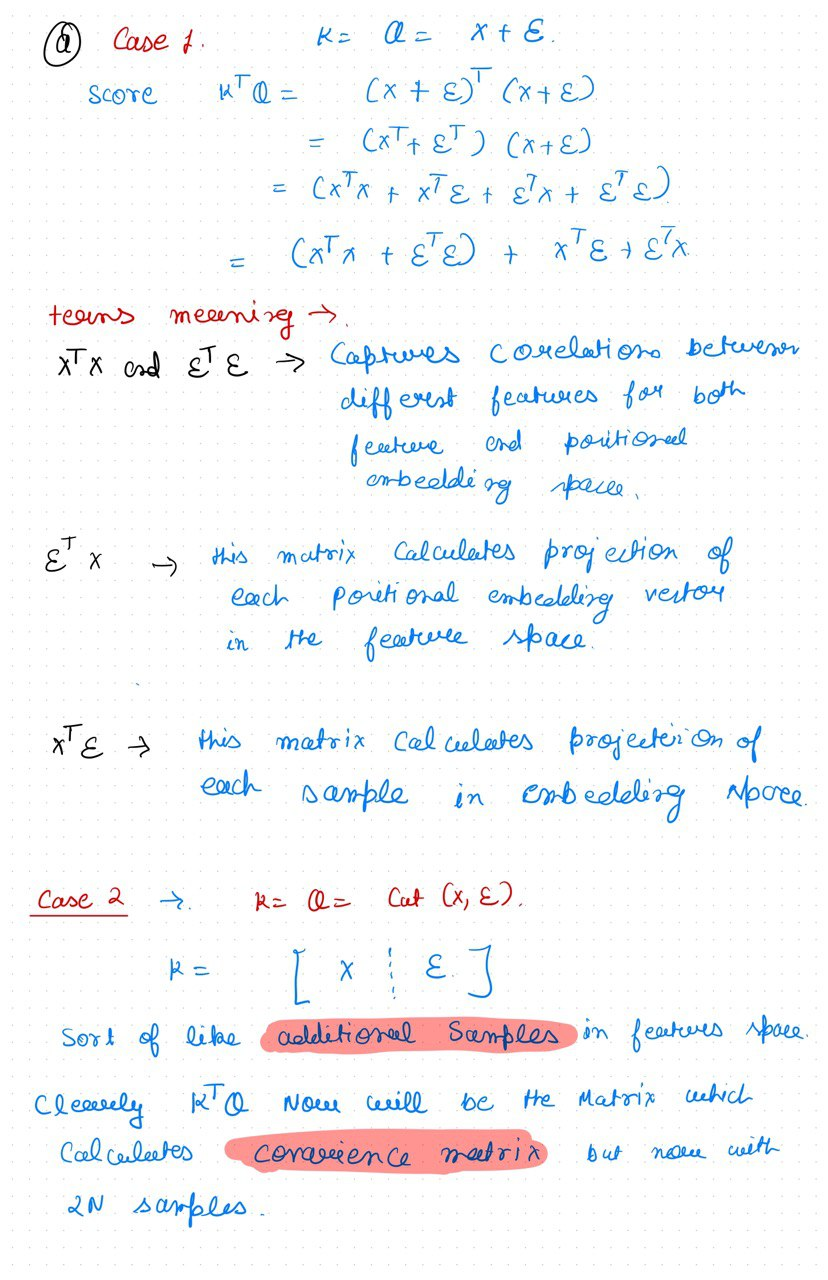

In [112]:
from IPython.display import Image

Image(filename = '1.(a).jpg')

In [113]:
p = 256
N = 64

E = np.zeros((p,N))


for k in range(int(p/2)):
    for i in range(0,N):
        exp = np.exp(-(k*np.log(10000))/p)
        E[2*k,i] = np.sin(2*i*exp)
        E[2*k+1,i] = np.cos(2*i*exp)




In [114]:
matrix = E.transpose()@E

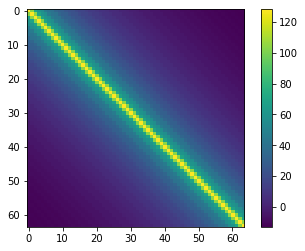

In [115]:
plt.imshow(matrix)
plt.colorbar()

We see that each embedding dimension is highly correlated with itself(which should be obvious) , thats the reason why we get sharp line diagonally.As we move away from one dimension to other the covariance oscillates and 'die' exponentially. It means that a particular random feature is correlated to it's nearest features locally as we move away this correlation becomes zero.We have also plotted particular row to demonstrate this - 

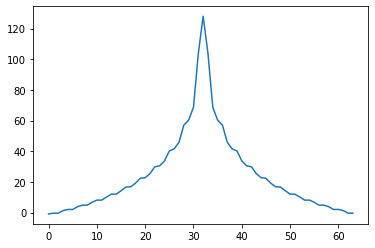

In [116]:
step =np.arange(0,64)
plt.figure()
plt.plot(step,matrix[32,:])
plt.show()

### 1.(C)

In [117]:
.shape

SyntaxError: invalid syntax (1189770672.py, line 1)

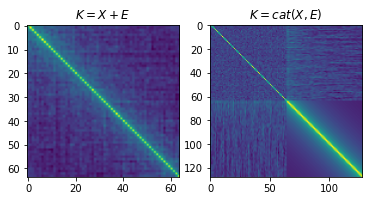

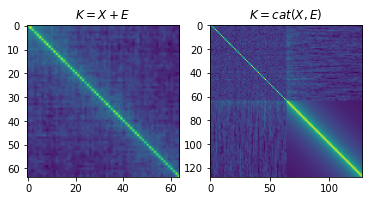

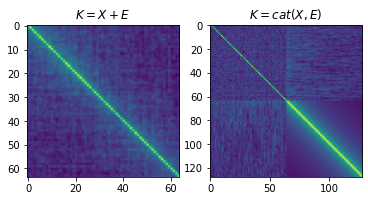

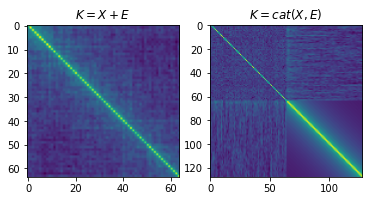

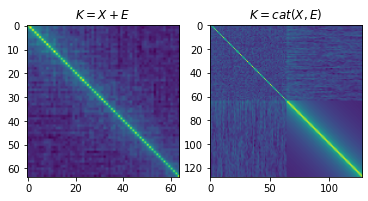

In [ ]:
##first we need to calculate the variance of E along axis = 1 and take the average

var = np.mean(np.var(E,axis =1))
mean = np.mean(np.mean(E,axis = 1))
##now we will be generating (p X N) elements from a gaussian with different mus and sigma = sqrt(var)
mu = np.mean(mean)
sigma = np.sqrt(var)


for i in range(5):  ## we will plot the scores for 5 different random features which has same sigma and mus like E
    X = np.random.normal(mu,sigma,size = (p,N))
    K = X + E
    fig,ax = plt.subplots(nrows=1,ncols = 2)
    ax[0].imshow(K.transpose()@K)
    ax[0].set_title(r'$K = X+E$')

    K = np.hstack((X,E))
  
    ax[1].set_title(r'$K = cat(X,E)$')

    ax[1].imshow(K.transpose()@K)
    plt.show()




we see that for K = X+E, the scores are peaked at diagonally(same feature) and as we move away from diagonal(particular feature) covariance is distributed randomly.

For concatenated part the image is divided into three main parts -
The top left and top right part captures the covariance matrix of the feature and embedding space. Whereas, off diagonal part captures covariance between feature and embedding space.

We can also say that (X+E) part is just the summed version of all constituents part of cat(X,E)


## 3 Observing Oversmoothing

In [ ]:
#@title Install Dependencies and get data from GitHub (will take a few minutes)
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install mamba -y
!mamba install -c rusty1s -c pytorch -c conda-forge -c lcerrone ctg-benchmark cpuonly torchmetrics=0.8.0 jupyter matplotlib

# get data from github
!git clone https://github.com/hci-unihd/mlph_sheet11/
!mv mlph_sheet11/ctg_data .

RuntimeError: This module must ONLY run as part of a Colab notebook!

In [ ]:
from ctg_benchmark.loaders.torch_loader import get_cross_validation_loaders, get_split_loaders
from ctg_benchmark.evaluation.metrics import NodeClassificationMetrics, aggregate_class
import torch
import numpy as np
from tqdm import trange
from tqdm.auto import tqdm
from torch_geometric.nn.models import GCN
from torch.optim import Adam
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ModuleNotFoundError: No module named 'ctg_benchmark'

In [ ]:
def validation(validation_loader, model):
    # set up evaluation
    eval_metrics = NodeClassificationMetrics(num_classes=9)

    accuracy_records, accuracy_class_records = [], []
    stds = []
    model.eval()
    # TODO: add calculation of mean feature std
    with torch.no_grad():
        for val_batch in validation_loader:
            val_batch = val_batch.to(device)
            pred = model.forward(val_batch.x, val_batch.edge_index)
            logits = torch.log_softmax(pred, 1)
            pred = logits.max(1)[1]
            # results is a dictionary containing a large number of classification metrics
            results = eval_metrics.compute_metrics(pred.cpu(), val_batch.y.cpu())
            acc = results['accuracy_micro']
            # aggregate class average the single class accuracy and ignores the embryo sack class (7)
            acc_class, _ = aggregate_class(results['accuracy_class'], index=7)

            accuracy_records.append(acc)
            accuracy_class_records.append(acc_class)
    return accuracy_records, accuracy_class_records


def simple_trainer(trainer_loader, num_layers=2):
    model = GCN(in_channels=74, hidden_channels=64, num_layers=num_layers, out_channels=9, dropout=0.5)
    model = model.to(device)
    optim = Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-5)
    t_range = trange(25, desc=f'Epoch: {0: 03d}, training loss: {0/len(trainer_loader): .2f}')
    # basic training loop
    for epoch in t_range:
        loss_epoch = 0
        for batch in trainer_loader:
            optim.zero_grad()
            batch = batch.to(device)
            pred = model.forward(batch.x, batch.edge_index)
            logits = torch.log_softmax(pred, 1)
            loss = F.nll_loss(logits, batch.y)
            loss.backward()

            optim.step()

            loss_epoch += loss.item()

        t_range.set_description(f'Epoch: {epoch + 1: 03d}, training loss: {loss_epoch/len(trainer_loader): .2f}')
        t_range.refresh()
    return model

In [ ]:
loaders = get_split_loaders(root='./ctg_data', batch_size=1, shuffle=True, grs=('label_grs_surface',))
training_loader, validation_loader = loaders['train'], loaders['val']

# example training for GCN with 1 layer
model = simple_trainer(training_loader, validation_loader, num_layers=1)
accuracy_records, accuracy_class_records = validation(validation_loader, model)

# report results
print(f'\nGCN results for {num_layers=}:')
print(f'Accuracy {np.mean(accuracy_records):.3f} std: {np.std(accuracy_records):.3f}')
print(f'Class Accuracy {np.mean(accuracy_class_records):.3f} std: {np.std(accuracy_class_records):.3f}')